## Motivation

This notebook demonstrates the practical considerations for perfoming dynamical evolution of an Hamiltonian written in the basis of Pauli matrices using a qubit-based quantum computer framework. The chosen Hamiltonian can be used to describe the chemical process of electron transfer across a chromophore chain, with the onsite parameters describing the strength of the electronic affinity at each chromophore and off-site couplings describing the barrier for transferring an electron between adjacent sites.

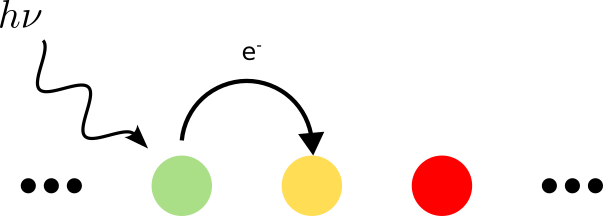

A problem of practical interest that could be modelled by this method would be a functionalized graphene nanoribbon, where alternating sites contain radical character ([Nano Lett. 2022, 22, 1, 164–171](https://pubs.acs.org/doi/10.1021/acs.nanolett.1c03578)).

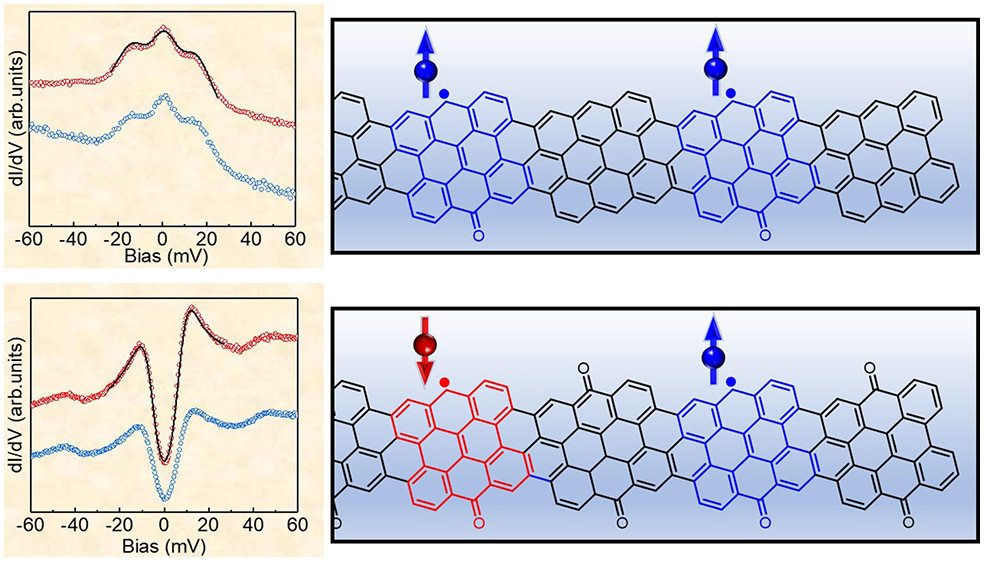

The stability of the radical character at each site can be described by the on-site parameter ($\Omega _n$) and the coupling between sites ($J _{n,n+1}$) governed by the properties of the linker regions containing the diketone groups. These parameters can be tuned by synthetic design of each component part of the nanoribbon.

\begin{equation}
H=  \sum_{n=0}^{N-1} \hbar \Omega _n \sigma_n ^z - \dfrac{1}{2} \sum_{n=0}^{N-2} \big(J_{n,n+1}^x \hat{\sigma}_{n}^x \hat{\sigma}_{n+1}^x + J_{n,n+1}^y \hat{\sigma}_{n}^y \hat{\sigma}_{n+1}^y + J_{n,n+1}^z \hat{\sigma}_{n}^z \hat{\sigma}_{n+1}^z \big)
\end{equation}

Protocol for Hamiltonian evolution in a quantum computer framework:

1.   Construct Hamiltonian operator (sum of tensor product of Pauli matrices)
2.   Construct Trotter approximation of time-evolution operator ($e^{-i\hat{H}t}$)
3.   Construct circuit corresponding to time-evolution operator
4.   Construct circuit for initial state
5.   Combine the initial state and time-evolution circuits
6.   Execute combined circuit
7.   Measure final state
8.   Computing observables with Hadamard test (correlation function and observables)

## Model Hamiltonian and Parameters

Here we use as an example the Hamiltonian for the Heisenberg model, defined as follows:
\begin{equation}
H=  \sum_{n=0}^{N-1} \hbar \Omega _n \sigma_n ^z - \dfrac{1}{2} \sum_{n=0}^{N-2} \big(J_{n,n+1}^x \hat{\sigma}_{n}^x \hat{\sigma}_{n+1}^x + J_{n,n+1}^y \hat{\sigma}_{n}^y \hat{\sigma}_{n+1}^y + J_{n,n+1}^z \hat{\sigma}_{n}^z \hat{\sigma}_{n+1}^z \big)
\end{equation}
where the coupling elements are described in terms of the $\sigma _x, \sigma _y, \sigma _z$ (Pauli X, Y and Z) matrices with a coupling associated with each type of interaction term for each site/pair of sites. We consider the following parameters, as used in the publication [Non-Markovian decay beyond the Fermi Golden Rule: Survival Collapse of the polarization in spin chains.](https://arxiv.org/pdf/quant-ph/0511176v2.pdf)(but with reduced number of spin sites):
\begin{align}
    N &= 3 \\
    \hbar \Omega _0 &= 0.65 \\
    \hbar \Omega _n &= 1.0, \; n > 0 \\
    J_{0,1}^x = J_{1,0}^y &= 0.75 \\
    J_{n,n+1}^x = J_{n,n+1}^y &= 1.0, \; n > 0  \\
    J_{n,n+1}^z &= 0, \; \forall n \\
\end{align}
for a chain of $N=3$ spins and an initial state with the first spin up, $| \uparrow \rangle = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$, and the remaining spins down, $| \downarrow \rangle = \begin{bmatrix} 0 \\ 1\end{bmatrix}$.
Although the dynamics of this Hamiltonian can be simulated in a classical computer, we could also use quantum computer to simulate this same problem. One way to do so is by harnessing Qiskit, a python library containing functions that ease the simulation of the problem in quantum device framework.

In [ ]:
# Ensure that the conda version of pip is the one being used
# to enforce that qiskit is contained within that environment
# Then run the following installation commands
!pip install 'qiskit==0.45.0'
!pip install 'qiskit-aer==0.13.0'
# !pip install 'qiskit-ibm-provider==0.7.2'

# If ttpy is needed for the classical simulations;
# this fork fixes some issues with the original repository maintained
# by Ivan Oseledets at git+https://github.com/oseledets/ttpy.git
# !pip install git+https://github.com/bcallen95/ttpy.git

## Construct Hamiltonian operator

In [ ]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_n_site_terms(n, coeff, n_qubits):
    '''
        Assembles each term in the Hamiltonian based on their Pauli string
        representation and multiplying by the respective coefficient.
    '''
    XX_coeff = coeff[0]
    YY_coeff = coeff[1]
    ZZ_coeff = coeff[2]
    Z_coeff = coeff[3]

    XX_term = SparsePauliOp(("I" * n + "XX" + "I" * (n_qubits - 2 - n)))
    XX_term *= XX_coeff
    YY_term = SparsePauliOp(("I" * n + "YY" + "I" * (n_qubits - 2 - n)))
    YY_term *= YY_coeff
    ZZ_term = SparsePauliOp(("I" * n + "ZZ" + "I" * (n_qubits - 2 - n)))
    ZZ_term *= ZZ_coeff
    Z_term = SparsePauliOp(("I" * n + "Z" + "I" * (n_qubits - 1 - n)))
    Z_term *= Z_coeff

    return (XX_term + YY_term + ZZ_term + Z_term)

In [ ]:
def get_heisenberg_hamiltonian(n_qubits, coeff=None):
    '''
        Takes an integer number corresponding to number of spins/qubits
        and a list of sublists containing the necessary coefficients
        to assemble the complete Hamiltonian:

            H = \sum _i ^N h_z Z_i
                + \sum _i ^{N-1} (h_xx X_iX_{i+1}
                                  + h_yy Y_iY_{i+1}
                                  + h_zz Z_iZ_{i+1}
                                 )

        Each sublist contains the [XX, YY, ZZ, Z] coefficients in this order.
        The last sublist should have the same shape, but only the Z component
        is used.
        If no coefficient list is provided, all are set to 1.
    '''

    # Three qubits because for 2 we get H_O = 0
    assert n_qubits >= 3

    if coeff == None:
        'Setting default values for the coefficients'
        coeff = [[1.0, 1.0, 1.0, 1.0] for i in range(n_qubits)]

    # Even terms of the Hamiltonian
    # (summing over individual pair-wise elements)
    H_E = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(0, n_qubits-1, 2)))

    # Odd terms of the Hamiltonian
    # (summing over individual pair-wise elements)
    H_O = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(1, n_qubits-1, 2)))

    # adding final Z term at the Nth site
    final_term = SparsePauliOp("I" * (n_qubits - 1) + "Z")
    final_term *= coeff[n_qubits-1][3]
    if (n_qubits % 2) == 0:
        H_E += final_term
    else:
        H_O += final_term

    # Returns the list of the two sets of terms
    return [H_E, H_O]

In [ ]:
num_q = 3
# XX YY ZZ, Z
ham_coeffs = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                + [[0.5, 0.5, 0.0, 1.0]
                for i in range(num_q-1)])

spin_chain_hamiltonian = get_heisenberg_hamiltonian(num_q,
                                                    ham_coeffs)
print('Hamiltonian separated into even and odd components:')
print(spin_chain_hamiltonian)
print('Hamiltonian combining even and odd components:')
print(sum(spin_chain_hamiltonian))

## Construct Trotter approximation of time-evolution operator ($e^{-i\hat{H}t}$)

In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
# Trotter-Suzuki implementation for decomposition of exponentials
# of matrices
from qiskit.synthesis import SuzukiTrotter
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np
from itertools import groupby
import re


def get_time_evolution_operator(num_qubits, tau, trotter_steps, coeff=None):
    '''
        Given a number of qubits, generates the corresponding time-evolution for
        the Ising model with the same number of sites.

        Input:
            num_qubits (int): number of qubits, which should be equal to the
                number of spins in the chain
            evo_time (float): time parameter in time-evolution operator
            trotter_steps (int): number of time steps for the Suzuki-Trotter
                decomposition
            coeff (list of lists): parameters for each term in the Hamiltonian
                for each site ie ([[XX0, YY0, ZZ0, Z0], [XX1, YY1, ZZ1, Z1], ...])
        Returns:
            evo_op.definition: Trotterized time-evolution operator
    '''
    # Constructing the Hamiltonian here;
    # heisenberg_hamiltonian = [H_E, H_O]
    heisenberg_hamiltonian = get_heisenberg_hamiltonian(num_qubits,
                                                        coeff)

    # e^ (-i*H*evo_time), with Trotter decomposition
    # exp[(i * evo_time)*(IIIIXXIIII + IIIIYYIIII + IIIIZZIIII + IIIIZIIIII)]
    evo_op = PauliEvolutionGate(heisenberg_hamiltonian, tau,
                                synthesis=SuzukiTrotter(order=2,
                                    reps=trotter_steps))
    # The Trotter order=2 applies one set of the operators for
    # half a timestep, then the other set for a full timestep,
    # then the first step for another half a step note that reps
    # includes the number of repetitions of the Trotterized
    # operator higher number means more repetitions, and thus
    # allowing larger timestep
    return evo_op.definition

In [ ]:
num_q = 3
evolution_timestep = 0.1
n_trotter_steps = 1
# XX YY ZZ, Z
ham_coeffs = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                + [[0.5, 0.5, 0.0, 1.0]
                for i in range(num_q-1)])
time_evo_op = get_time_evolution_operator(
    num_qubits=num_q, tau=evolution_timestep,
    trotter_steps=n_trotter_steps, coeff=ham_coeffs)
print(time_evo_op)

3.   Construct circuit corresponding to time-evolution operator

8.   Computing observables with Hadamard test (correlation function and observables)

## Alternative Propagator Based on Pauli Hamiltonian with at most 2-site interactions

In [ ]:
def find_string_pattern(pattern, string):
    match_list = []
    for m in re.finditer(pattern, string):
        match_list.append(m.start())
    return match_list


# efficient propagator for pauli hamiltonians
def sort_Pauli_by_symmetry(ham):
    '''
        Separates a qiskit PauliOp object terms into 1 and 2-qubit
        operators. Furthermore, 2-qubit operators are separated according
        to the parity of the index first non-identity operation.
    '''
    one_qubit_terms = []
    two_qubit_terms = []
    # separating the one-qubit from two-qubit terms
    for term in ham:
        matches = find_string_pattern('X|Y|Z', str(term.paulis[0]))
        pauli_string = term.paulis[0]
        coeff = np.real(term.coeffs[0])
        str_tag = pauli_string.to_label().replace('I', '')
        if len(matches) == 2:
            two_qubit_terms.append((pauli_string, coeff, matches, str_tag))
        elif len(matches) == 1:
            one_qubit_terms.append((pauli_string, coeff, matches, str_tag))

    # sorting the two-qubit terms according to index on which they act
    two_qubit_terms = sorted(two_qubit_terms, key=lambda x: x[2])
    # separating the even from the odd two-qubit terms
    even_two_qubit_terms = list(filter(lambda x: not x[2][0]%2, two_qubit_terms))
    odd_two_qubit_terms = list(filter(lambda x: x[2][0]%2, two_qubit_terms))

    even_two_qubit_terms = [list(v) for i, v in groupby(even_two_qubit_terms, lambda x: x[2][0])]
    odd_two_qubit_terms = [list(v) for i, v in groupby(odd_two_qubit_terms, lambda x: x[2][0])]

    return one_qubit_terms, even_two_qubit_terms, odd_two_qubit_terms


def generate_circ_pattern_1qubit(circ, term, delta_t):
    '''
        General 1-qubit gate for exponential of product identity and
        a single pauli gate.
        Only a single rotation operation is required, with the angle
        being related to the exponential argument:

        R_P(coeff) = exp(-i * coeff * P / 2)

        Where P is the Pauli gate and coeff encompasses the constant
        coefficient term
    '''
    coeff = 2 * term[1] * delta_t
    if term[3] == 'X':
        circ.rx(coeff, term[2])
    elif term[3] == 'Y':
        circ.ry(coeff, term[2])
    elif term[3] == 'Z':
        circ.rz(coeff, term[2])

    return circ


def generate_circ_pattern_2qubit(circ, term, delta_t):
    '''
        General 2-qubit gate for exponential of Paulis. This is the
        optimal decomposition, based on a component of a U(4) operator.
        (see )

        The circuit structure is as follows:

        - ---- I ---- C - Rz(o) - X --- I --- C - Rz(pi/2) -
        - Rz(-pi/2) - X - Ry(p) - C - Ry(l) - X ---- I -----

        Where CX represent CNOT operations, R are rotation gates with angles,
        and I is the identity matrix. The angles are parameterized as follows:

        o = \theta = (\pi/2 - A)
        p = \phi = (A - \pi/2)
        l = \lambda = (\pi/2 - A)

        Where A is the exponential argument.
    '''
    # wires to which to apply the operation
    wires = term[0][2]

    # angles to parameterize the circuit,
    # based on exponential argument
    if any('XX' in sublist for sublist in term):
        g_phi = ( 2 * (-1) * term[0][1] * delta_t - np.pi / 2)
    else:
        g_phi = - np.pi / 2
    if any('YY' in sublist for sublist in term):
        g_lambda = (np.pi/2 - 2 * (-1) * term[1][1] * delta_t)
    else:
        g_lambda = np.pi/2
    if any('ZZ' in sublist for sublist in term):
        g_theta = (np.pi/2 - 2 * (-1) * term[2][1] * delta_t)
    else:
        g_theta = np.pi/2

    # circuit
    circ.rz(-np.pi/2, wires[1])
    circ.cx(wires[1], wires[0])
    circ.rz(g_theta, wires[0])
    circ.ry(g_phi, wires[1])
    circ.cx(wires[0], wires[1])
    circ.ry(g_lambda, wires[1])
    circ.cx(wires[1], wires[0])
    circ.rz(np.pi/2, wires[0])
    return circ


def get_manual_Trotter(num_q, pauli_ops, timestep, n_trotter=1,
                       trotter_type='basic', reverse_bits=True):
    # sorts the Pauli strings according to qubit number they affect and symmetry
    one_q, even_two_q, odd_two_q = sort_Pauli_by_symmetry(pauli_ops)
    # scales the timestep according to the number of trotter steps
    timestep_even_two_q = timestep / n_trotter
    timestep_odd_two_q = timestep / n_trotter
    timestep_one_q = timestep / n_trotter
    # symmetric places 1/2 of one_q and odd_two_q before and after even_two_q
    if trotter_type == 'symmetric':
        timestep_odd_two_q /= 2
        timestep_one_q /= 2
    # constructs circuits for each segment of the operators
    qc_odd_two_q, qc_even_two_q, qc_one_q = QuantumCircuit(num_q), QuantumCircuit(num_q), QuantumCircuit(num_q)
    for i in even_two_q:
        qc_even_two_q = generate_circ_pattern_2qubit(qc_even_two_q, i, timestep_even_two_q)
    for i in odd_two_q:
        qc_odd_two_q = generate_circ_pattern_2qubit(qc_odd_two_q, i, timestep_odd_two_q)
    for i in one_q:
        qc_one_q = generate_circ_pattern_1qubit(qc_one_q, i, timestep_one_q)
    # assembles the circuit for Trotter decomposition of exponential
    qr = QuantumRegister(num_q)
    qc = QuantumCircuit(qr)
    if trotter_type == 'basic':
        qc = qc.compose(qc_even_two_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_one_q)
    elif trotter_type == 'symmetric':
        qc = qc.compose(qc_one_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_even_two_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_one_q)
    # repeats the single_trotter circuit several times to match n_trotter
    for i in range(n_trotter-1):
        qc = qc.compose(qc)
    if reverse_bits:
        return qc.reverse_bits()
    else:
        return qc

In [ ]:
spin_chain_hamiltonian = get_heisenberg_hamiltonian(num_q,
                                                    ham_coeffs)

spin_chain_hamiltonian = sum(spin_chain_hamiltonian)
print(get_manual_Trotter(num_q, spin_chain_hamiltonian,
                            0.1).draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            n_trotter=2).draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            trotter_type='symmetric').draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            n_trotter=2,
                            trotter_type='symmetric').draw())

## Preliminary Walkthrough of Setting up Initial Circuits

### Parameters

In [ ]:
# used to compile the circuit, tranpiling to the set of
# operations supported by the device backend and execution
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit import execute
from qiskit import BasicAer


num_q = 3
evolution_timestep = 0.1
n_trotter_steps = 1
# XX YY ZZ, Z
hamiltonian_coefficients = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                            + [[0.5, 0.5, 0.0, 1.0]
                                for i in range(num_q-1)])
num_shots = 100

### Construct circuit for initial state

In [ ]:
# specifying a quantum register with specific number of qubits
qr = QuantumRegister(num_q)
# classical register used for measurement of qubits
cr = ClassicalRegister(num_q)
# quantum circuit combining quantum and classical registers
qc = QuantumCircuit(qr, cr) # instantiated here
qc.draw(style='iqp')
print(qc)

# specifying initial state by flipping qubit states
for qubit_idx in range(num_q):
    if qubit_idx == 0:
        # generate only one spin-up at first qubit
        qc.id(qubit_idx)
    else:
        # make all other spins have the spin-down state
        qc.x(qubit_idx)
qc.barrier()
qc.draw(style='iqp')
print(qc)

# checking the initial state
device = BasicAer.get_backend('statevector_simulator')
qc_init_state = execute(qc, backend=device).result()
qc_init_state = qc_init_state.get_statevector()
print(qc_init_state)

### Combine the initial state and time-evolution circuits

In [ ]:
# generating the time evolution operator for a specific set of
# hamiltonian parameters and timestep
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=hamiltonian_coefficients)

# appending the Hamiltonian evolution to the circuit
qc.append(time_evo_op, list(range(num_q)))
qc.barrier()
qc.draw(style='iqp')
print(qc)

# Depth check
print('Depth of the circuit is', qc.depth())
# transpiled circuit to statevector simulator
qct = transpile(qc, device, optimization_level=2)
qct.decompose().decompose()
qct.draw(style='iqp')
print(qct)

print('Depth of the circuit after transpilation is '
        f'{qct.depth()}')

### Execute combined circuit and measure final state

In [ ]:
# showcasing simple execution
qct_run = execute(qct, device, shots=1270).result()
qct_run_counts = qct_run.get_counts()
print(f'Circuit measurement counts {qct_run_counts}')

## Google Collab Setup (if using)

In [ ]:
#Mount your google drive as follows:
from google.colab import drive
drive.mount('/content/mydir')

# Query name of current folder
import os
folder_name=os.getcwd()
print(folder_name)

# Goto the Colab folder; should switch this to the actual google-drive folder
# where the notebook is located
os.chdir('/content/mydir/MyDrive/QuantumComputingQiskit/General_Tutorials')

folder_name=os.getcwd()
print(folder_name)

## Performing Statevector Evolution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import execute
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import BasicAer


# Quantum circuit for propagation
def qsolve_statevector(psin, qc):
    '''
        Performs dynamical propagation for a specific quantum circuit, using the
        an initial state equal to the result of the prior iteration. In effect,
        this propagates:

        | \psi _t \rangle  = e^{i*\tau*H/hbar} e^{i*\tau*H/hbar} ... | \psi _0 \rangle
        -> | \psi _t \rangle  = e^{i*\tau*H/hbar} | \psi _{t-\tau} \rangle

        Use of reinitialization in this way is possible due to the usage of the
        statevector_simulator backend; this may not be practical for an
        implementation on actual hardware.
        Returns:
            psin (statevector): final statevector after execution
    '''
    # Determining number of qubits from the length of the state vector
    n=np.size(psin)
    d=int(np.log2(np.size(psin)))
    # Circuit preparation
    qre = QuantumRegister(d)
    circ = QuantumCircuit(qre)
    circ.initialize(psin,qre)
    circ.barrier()
    # for i in range(0,100):
    circ.append(qc, qre)
    circ.barrier()
    # Circuit execution
    device = BasicAer.get_backend('statevector_simulator')
    psin = execute(circ, backend=device).result()
    psin = psin.get_statevector()
    return psin

Parameters:

In [ ]:
num_q = 3
evolution_timestep = 0.1
n_trotter_steps = 1
# XX YY ZZ, Z
hamiltonian_coefficients = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                            + [[0.5, 0.5, 0.0, 1.0]
                                for i in range(num_q-1)])
num_shots = 100

# Qubit basis states
zero_state = np.array([[1],[0]])
one_state = np.array([[0],[1]])

# For a 011 initial state prepare as follows
psin = zero_state # for the first spin
# iterates over the remaining spins, by performing
# Kronecker Product
for i in range(num_q-1):
    psin = np.kron(psin, one_state)
psin0 = psin.flatten()
print(psin0)

# time evolution operator
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=hamiltonian_coefficients)

Dynamics:

In [ ]:
# number of steps for which to propagate
# (totaling 25 units of time)
nsteps = 250
psin_list = []
psin_list.append(psin0)
correlation_list = []
# performs dynamical propagation by statevector re-initialization
for k in range(nsteps):
    print(f'Running dynamics step {k}')
    if k > 0:
        psin = qsolve_statevector(psin_list[-1], time_evo_op)
        # removes the last initial state to save memory
        psin_list.pop()
        # stores the new initial state
        psin_list.append(psin)
    correlation_list.append(np.vdot(psin_list[-1],psin0))

t = np.arange(0, evolution_timestep*(nsteps),
                evolution_timestep)
np.save(f'{num_q}_spin_chain_time', t)
sa_observable = np.abs(correlation_list)
np.save(f'{num_q}_spin_chain_SA_obs', sa_observable)
# plotting
plt.plot(t, sa_observable, '-o')
plt.ylabel('Survival Amplitude')
plt.yscale('log')
plt.show()

## Hadamard Test Preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import execute, BasicAer
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister


def get_hadamard_test(num_q, initial_state, control_operation,
                      control_repeats=0, imag_expectation=False):
    '''
        Writes the Hadamard test circuit to evaluate the real (or imaginary)
        components of a given operator (or set of operators) by measuring the
        ancilla.

        Inputs:
            num_qubits (int): number of qubits needed for the calculation
            initial_state: quantum circuit object containing the initialization
                for the system
            control_operation: quantum circuit object containing the controlled
                version of the unitary operator for which to evaluate the
                expectation value
            control_repeats (int): number of repetitions of the controlled
                operation in the Hadamard test circuit (such as time-propagation)
            imag_expectation (boolean): whether to assemble the circuit for
                evaluation of the real or imaginary components of the operator.
        Returns:
            qc_hadamard: quantum circuit object containing the hadamard test
    '''
    # Circuit object framework
    qr_hadamard = QuantumRegister(num_q+1)
    cr_hadamard = ClassicalRegister(1)
    qc_hadamard = QuantumCircuit(qr_hadamard, cr_hadamard) # instantiated here
    # Initialization of calculation qubits
    qc_hadamard.append(initial_state, qr_hadamard[1:]) # initial psi
    qc_hadamard.barrier()
    # Hadamard test structure
    qc_hadamard.h(0)
    if imag_expectation:
        qc_hadamard.p(-np.pi/2, 0) # qc_hadamard.s(0).inverse() may be equivalent
    # iterates over the number of times the control operation should be added
    for i in range(control_repeats):
        qc_hadamard.append(control_operation, qr_hadamard[:])
    qc_hadamard.h(0)
    qc_hadamard.barrier()
    # Measuring the ancilla
    qc_hadamard.measure(0,0)
    return qc_hadamard


def get_circuit_execution_counts(qc, backend, n_shots=100):
    '''
        Takes a quantum circuit, Qiskit supported backend and a specified number
        of execution times to calculate the number of times each state in the
        circuit was measured.

        Inputs:
            qc: Qiskit quantum circuit object
            backend: qiskit supported quantum computer framework (either simulator
                or actual device)
                n_shots (int): default=100; number of times for which to execute
                    the circuit using the specified backend.
    '''
    qc_execution = execute(qc, backend, shots=n_shots)
    counts = qc_execution.result().get_counts()
    return counts # number of times measured 0 and 1


def get_spin_correlation(counts):
    '''
        Generates the spin correlation at a particular time by averaging over
        the counts of the ancillary qubit.
    '''

    qubit_to_spin_map = {
        '0': 1,
        '1': -1,
    }
    total_counts = 0
    values_list = []
    for k,v in counts.items():
        values_list.append(qubit_to_spin_map[k] * v)
        total_counts += v
    average_spin = (sum(values_list)) / total_counts
    return average_spin


def get_initialization(num_qubits, initialization_string):
    '''
        Creates a circuit containing the qubit initialization for a specified
        number of qubits and given initialization string. There are alternative
        methods to initialize the circuit besides the one used in this function
        including using a statevector or amplitude embedding of an arbitrary state.
    '''
    qr_init = QuantumRegister(num_qubits)
    qc_init = QuantumCircuit(qr_init)
    qc_init.initialize(initialization_string, qr_init[:]) # 0x1x1
    return qc_init

## Hadamard Test Execution

Preparation:

In [ ]:
# switch this variable to True to execution the 'for' loop.
# it takes >1hr for 3 spins, with the parameters defined above
# and 1000 shots for each time step.
# run_hadamard_test_boolean = False
run_hadamard_test_boolean = True

# IMPORTANT: Use qasm_simulator to obtain meaningful statistics
# statevector is not appropriate for this method
simulator = BasicAer.get_backend('qasm_simulator')

num_q = 3
n_trotter_steps = 1
# XX YY ZZ, Z
hamiltonian_coefficients = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                            + [[0.5, 0.5, 0.0, 1.0]
                                for i in range(num_q-1)])

num_shots = 100 # increase to check for convergence

evolution_timestep=0.1
total_time = 2.5
time_range = np.arange(0, total_time+evolution_timestep,
                        evolution_timestep)


# time evolution operator
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=hamiltonian_coefficients)
# for closed controlled operation (ie if qubit is 1)
controlled_time_evo_op = time_evo_op.control()
# for open controlled operation (ie if qubit is 0);
# not used here for this correlation fxn but needed for others
# controlled_time_evo_op = time_evo_op.control(ctrl_state=0)
print(controlled_time_evo_op.decompose())


init_state_list = '1' + '0' * (num_q-1)
init_circ = get_initialization(num_q, init_state_list)
init_circ.draw(style='iqp')
print(init_circ)

Hadamard test dynamics:

In [ ]:
# lists t store observables
if run_hadamard_test_boolean:
    real_amp_list = []
    imag_amp_list = []
    for idx,time in enumerate(time_range):
        print(f'Running dynamics step {idx}')
        # Real component ------------------------------
        qc_had_real = get_hadamard_test(num_q, init_circ,
                                        controlled_time_evo_op,
                                        control_repeats=idx,
                                        imag_expectation=False)
        had_real_counts = get_circuit_execution_counts(
                qc_had_real, simulator, n_shots=num_shots)
        real_amplitude = get_spin_correlation(had_real_counts)
        real_amp_list.append(real_amplitude)

        # Imag component ------------------------------
        qc_had_imag = get_hadamard_test(num_q, init_circ,
                                        controlled_time_evo_op,
                                        control_repeats=idx,
                                        imag_expectation=True)
        had_imag_counts = get_circuit_execution_counts(
                qc_had_imag, simulator, n_shots=num_shots)
        imag_amplitude = get_spin_correlation(had_imag_counts)
        imag_amp_list.append(imag_amplitude)
        print(f'Finished step {idx}, where '
                f'Re = {real_amplitude:.3f} '
                f'Im = {imag_amplitude:.3f}')

    real_amp_array = np.array(real_amp_list)
    imag_amp_array = np.array(imag_amp_list)

    print('Saving data...')
    # real and imaginary amplitude components
    np.savetxt('real_amp_array.csv', real_amp_array,
                fmt='%.18e', delimiter=';', newline='\n')
    np.savetxt('imag_amp_array.csv', imag_amp_array,
                fmt='%.18e', delimiter=';', newline='\n')
    # survival amplitude
    np.savetxt('np_abs_correlation_with_hadamard_test.csv',
                np.abs(real_amp_array + 1j*imag_amp_array),
                fmt='%.18e', delimiter=';', newline='\n')
    # survival probability
    np.savetxt('np_sqrt_sum_squares_correlation_with_hadamard'
                '_test.csv',
                np.sqrt(real_amp_array**2 + imag_amp_array**2),
                fmt='%.18e', delimiter=';', newline='\n')
real_amp_array = np.loadtxt('real_amp_array.csv',
                            delimiter=';')
imag_amp_array = np.loadtxt('imag_amp_array.csv',
                            delimiter=';')
np_abs_correlation_with_hadamard_test = np.loadtxt(
        'np_abs_correlation_with_hadamard_test.csv',
        delimiter=';')
np_sqrt_sum_squares_correlation_with_hadamard_test = np.loadtxt(
        'np_sqrt_sum_squares_correlation_with_hadamard_test.csv',
        delimiter=';')


# plotting the data
plt.plot(time_range, np_abs_correlation_with_hadamard_test,
            '.', label='Hadamard Test')

sa_statevector = np.load(f'data/{num_q}_spin_chain_SA_obs.npy')
time = np.load(f'data/{num_q}_spin_chain_time.npy')
plt.plot(time, sa_statevector, '-', label='Statevector')

plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude')
plt.legend()
plt.show()

# Results Plotting (all-together)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


dpi=300
plt.style.use('plot_style.txt')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 11
plt.rcParams["figure.figsize"] = (19.20, 10.80)


num_q = 3

# data folder
fdir = 'data/'
# classical benchmark
sa_tt_ksl = np.load(fdir + f'TT_{num_q}_spin_chain_sa_ksl.npy')
sa_tt_taylor = np.load(fdir+f'TT_{num_q}_spin_chain_sa_Taylor'
                        + '.npy')
sa_tt_chebyshev = np.load(fdir + f'TT_{num_q}_spin_chain_sa_'
                            + 'Chebyshev.npy')
tt_time = np.load(fdir + f'TT_{num_q}_spin_chain_time.npy')

# statevector results
sa_statevector = np.load(fdir+f'{num_q}_spin_chain_SA_obs.npy')
time = np.load(fdir + f'{num_q}_spin_chain_time.npy')

# hadamard test results
sa_corr = np.loadtxt(fdir + 'np_abs_correlation_'
                        'with_hadamard_test.csv', delimiter=';')
sq_corr = np.loadtxt(fdir + 'np_sqrt_sum_squares_correlation_'
                        'with_hadamard_test.csv', delimiter=';')

# plotting the data
plt.plot(time, sa_tt_taylor, '-', label='TT-Taylor',
            linewidth=13)
plt.plot(time, sa_tt_chebyshev, '-', label='TT-Chebyshev',
            linewidth=9)
plt.plot(time, sa_tt_ksl, '-', label='TT-KSL',
            linewidth=5, color='gainsboro')
plt.plot(time, sa_statevector, '--', label='Statevector')
plt.plot(time, sa_corr, '*', label=r'Hadamard Test, $\mathfrak{Re}+i\mathfrak{Im}$')
plt.xlabel(r'Time $\mathfrak{Re}$')
plt.ylabel('Absolute Value of Survival Amplitude, '
            r'$\left|\langle \psi | \psi \rangle \right|$')
plt.xlim((min(time), max(time)))
plt.yscale('log')
plt.legend()
plt.savefig('method_comparison.pdf', format='pdf', dpi=dpi)
plt.savefig('method_comparison.png', format='png', dpi=dpi)
plt.show()